# このコースの目標

このコースでは、機械学習を利用したクラス分類問題を、実問題を利用して一通り問いてみることに焦点をあてます。
まず前半は、酵母の表現型データベースである、[SCMD (Saccaromices cerevisiae Morphology Database)](http://scmd.gi.k.u-tokyo.ac.jp/datamine/) ([Ohya, Sese et al. PNAS 2005](http://www.pnas.org/content/102/52/19015), [Saito et al. NAR 2004](https://academic.oup.com/nar/article/32/suppl_1/D319/2505341)) のデータを利用して、酵母の画像（および、画像から抽出した特徴量）から、各細胞の細胞周期を同定する機械学習を実施します。後半は、世界のChIP-seqデータ(転写因子結合サイト実験)を収集し解析したデータベースである[ChIP-Atlas](https://chip-atlas.org/) ([Oki et al. EMBO reports 2018](http://embor.embopress.org/content/early/2018/11/07/embr.201846255)) から、一次解析の終了したChIP-seqデータを基に、転写因子結合の有無を予測します。

# 準備

機械学習の実施にあたっては、言語としてPythonを用い、Pythonの機械学習ライブラリであるScikit-learn、および、深層学習ライブラリである PyTorch を利用して、予測の実施を見ていきます。本コースでは、下記の環境が予め整っていることを想定しています。
* Python >= 3.6
* Anaconda 3
    * Sckit learn、numpy、pandas などの機械学習でよく利用するパッケージが一括でインストールできます。

PyTorch をインストールするため、下記のコマンドを実行します。
```bash
$ pip install torch torchvision
```

# 酵母の細胞周期情報の俯瞰（特徴量データから）

SCMD には、酵母の画像情報とともに、ソフトウエア[CalMorph](http://scmd.gi.k.u-tokyo.ac.jp/datamine/calmorph/)で抽出された、各細胞の測定値（細胞の長径、短径、染色されたDNAの面積など）が格納されています。
ここでは、CalMorphで出力されている細胞形態に関する特徴量（数値、情報）から、細胞周期を予測してみます。

SCMDには、多数の遺伝子破壊株の情報が保存されていますが、PNASの論文で基準の表現型として扱われているHIS3遺伝子(YOR202w)の破壊株を利用します。
SCMDの上のタブから、Photo>Photo Viewer を選択すると、画像が見られます。

![SCMD](img/scmd_top.png)

* 細胞の形態情報の例(http://scmd.gi.k.u-tokyo.ac.jp/datamine/ViewDataSheet.do?orf=YOR202w)

![Photo Viewer](img/scmd_photoviewer.png)

講義資料でも触れていますが、一般的にはいきなり予測を実施するのではなく、データ全体を俯瞰して、予測に足るデータであるかどうかの調査を実施します。まずは、ここから始めましょう。具体的には、データを図示したり、PCAを実施します。

ここでは、すでにHIS3破壊株の特徴量をダウンロードしたデータを準備してあり、"data/yeast_his3.csv" に格納してあります。
このデータをPandasを使って、読み込んで見ましょう。

In [1]:
import numpy as np
import pandas as pd
data = pd.read_csv("data/yeast_his3.csv")

読み込んだデータの先頭5個を表示します。

In [2]:
data.head()

,PhotoID,CellID,Cgroup,Agroup,Dgroup,C11-1,C11-2,C101,C103,C104,...,D111,D112,A101,A102,A103,A104,A120,A121,A122,A123
0,2,0,medium,iso,A1,853.0,347.0,1200.0,35.4,29.1,...,NaN,0.293,0.256,0.629,NaN,0.124,118.0,47.3,3.0,0.537
1,2,1,no,B,A,822.0,NaN,822.0,34.4,29.3,...,NaN,NaN,0.127,NaN,NaN,NaN,64.4,26.3,2.0,0.375
2,2,2,large,F,C,791.0,503.0,1290.0,34.1,29.3,...,NaN,0.516,0.165,0.528,0.000242,NaN,119.0,46.8,4.0,0.832
3,2,3,medium,iso,B,731.0,354.0,1090.0,34.0,26.0,...,NaN,0.463,0.266,0.737,NaN,0.181,112.0,46.3,4.0,0.519
4,2,4,medium,iso,C,841.0,388.0,1230.0,34.5,29.6,...,NaN,0.290,0.264,0.914,NaN,0.159,110.0,47.4,3.0,0.415


各行は、画像内の1細胞の情報を示しています。はじめの２列 (PhotoID, CellID) は画像番号と画像内の細胞番号、次の３列（Cgroup, Agroup, Dgroup）が細胞周期に関連した分類で、芽の大きさでの分類、アクチンの分類、DNA状態での分類です。その次、C11-1 以降は、特徴量の番号(Cから始まるものは細胞壁、DはDNA、Aはアクチン由来)になっており、それらの意味は、[Parameter Help](http://scmd.gi.k.u-tokyo.ac.jp/datamine/ParameterHelp.do)の Cell Parameter List に記載してあります。

本来であれば、すべてのデータを利用したいところですが、前項の図示した結果を見ても分かる通り、細胞の状態によって取得できない値も存在します。例えば、分裂開始前の細胞からは、芽の大きさは取得できません。このため、今回のデータには多くの欠損値が存在します。一方で、欠損値の取扱は、ケースバイケースであり、本講義の主眼からははずれるため、欠損値の少ない（無い）いくつかのパラメータに絞ったデータを作成して、予測を行います。

例えば、各パラメータの欠損値数を数えてみると、ほとんどのパラメータに何らかの欠損値が存在します。

In [3]:
np.sum(data.isnull(), axis=0) 

PhotoID      0
CellID       0
Cgroup       0
Agroup       0
Dgroup       0
C11-1        5
C11-2      120
C101         5
C103         5
C104         5
C105       120
C106       120
C108       127
C109       120
C110       120
C111       120
C112       120
C113       120
C114       127
C115         5
C107       120
D105       264
D106       121
D104        86
D107        86
D109       275
D108       121
D110       200
D111       378
D112       121
A101         6
A102       120
A103       335
A104       163
A120         6
A121         6
A122         6
A123         6
dtype: int64

今回は簡単のため、欠損値の少ないパラメータのみを抽出し、更に、欠損値のある細胞は解析対象から除外して、解析します。

In [4]:
columns = ["C101", "C103", "C104","C115","A101","A120","A121","A122","A123"]
# "Cgroup"とcolumnsに記載したカラムのみのデータを作成
cell_features_pre = data[["Cgroup"] + columns]
# 欠損値のある細胞を除外
cell_features = cell_features_pre[np.sum(cell_features_pre.isnull(), axis=1) == 0]

cell_features_pre と cell_features の行数、列数を調べます。

In [5]:
cell_features_pre.shape

(378, 10)

In [6]:
cell_features.shape

(372, 10)

6行（細胞）分、データが削られたことがわかります。ちなみに、削られたのは下記の6個の細胞です。

In [7]:
cell_features_pre[np.sum(cell_features_pre.isnull(), axis=1) != 0]

,Cgroup,C101,C103,C104,C115,A101,A120,A121,A122,A123
83,complex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,complex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,no,738.0,33.4,26.5,1.26,NaN,NaN,NaN,NaN,NaN
270,complex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
294,complex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
374,complex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


複数の細胞が分離できなかったケース（Cgroupがcomplex）が多くなっています。

残ったデータの芽の大きさ分布を見てみましょう。

In [8]:
import collections
collections.Counter(np.array(cell_features["Cgroup"]))

Counter({'medium': 88, 'no': 114, 'large': 97, 'small': 73})

芽のない細胞（"no"）が少し多めですが、大きな偏りも無いようです。

この状態で、細胞壁の状態と細胞の大きさに関して可視化をしてみましょう。細胞の大きさ（C101: Cell size)と母細胞の長径（C103: Long axis length of mother cell)をX軸とY軸とし、芽の大きさを色で表した散布図を描画します。

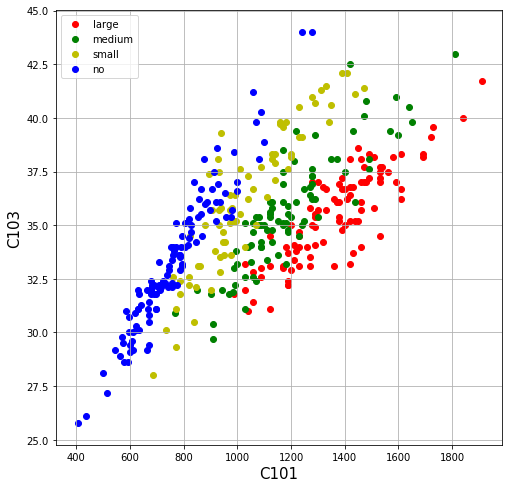

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
targets = ['large', 'medium', 'small', 'no']
colors = ['r', 'g', 'y', 'b']
xlabel = "C101" # Cell size
ylabel = "C103" # Long axis length of mother cell
ax.set_xlabel(xlabel, fontsize = 15)
ax.set_ylabel(ylabel, fontsize = 15)
for target, color in zip(targets,colors):
    target_row = cell_features['Cgroup'] == target
    ax.scatter( cell_features.loc[target_row, xlabel]
               , cell_features.loc[target_row, ylabel]
               , c = color)
ax.legend(targets)
ax.grid()

細胞の大きさ(C101)が大きくなるにつれて、芽の大きさが大きくなる傾向が見えますが、細胞の大きさだけでは芽の大きさを分離することは難しそうです。母細胞の長径(C103)も合わせて見ることで、ある程度、芽の大きさを分離できそうなことがわかります。
また、重要な点として、X軸とY軸で全くスケールが違うことが挙げられます。このようなスケールの違いは、この後のPCAや機械学習のステップに大きな影響を及ぼす（たとえば分散を考えた場合、もとの値が大きいほうが分散が大きく見えてしまう）ので、スケールを合わせます。

scikit-learn の preprocessing に、正規化（平均0, 分散1への変換）をしてくれる関数 StandardScaler が用意されているので、利用します。

In [10]:
from sklearn import preprocessing
X = cell_features[columns] # 単位の変換に、クラス名は必要ないので削除
X_norm = preprocessing.StandardScaler().fit_transform(X)

In [11]:
X_norm

array([[ 0.42516505,  0.12946103,  0.08625753, ...,  1.24377445,
        -0.21082534, -0.44642697],
       [-0.863805  , -0.19224574,  0.15445689, ..., -0.49399376,
        -0.74434253, -0.8675696 ],
       [ 0.73206269, -0.28875778,  0.15445689, ...,  1.20239902,
         0.32269185,  0.32046854],
       ...,
       [-0.086331  , -0.28875778, -0.15244024, ..., -1.79318237,
        -1.27785972, -1.00795047],
       [-0.35230895,  0.45116781, -0.18653992, ..., -1.63595573,
        -1.27785972, -0.42043052],
       [-1.23890211, -0.96434201, -0.62983577, ..., -2.02405729,
        -1.27785972,  0.12809475]])

この変換により、単位が変換されているだけでなく、型がPandasのDataFrameから、Numpyのarrayになっていることも、要注意してください。

さて、前置きが長くなりましたが、主成分分析を実施します。

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc_matrix = pca.fit_transform(X_norm)
pc_df = pd.DataFrame(data = pc_matrix, columns = ['PC1', 'PC2'])
pc_df['Cgroup'] = np.array(cell_features["Cgroup"])

主成分分析の結果を可視化します。

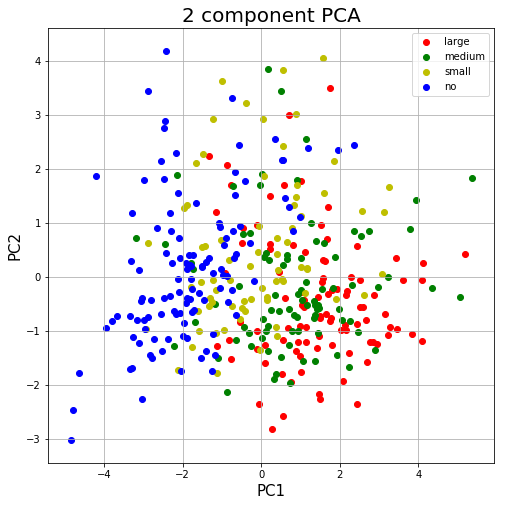

In [13]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['large', 'medium', 'small', 'no']
colors = ['r', 'g', 'y', 'b']
for target, color in zip(targets,colors):
    target_row = pc_df['Cgroup'] == target
    ax.scatter(pc_df.loc[target_row, 'PC1']
               , pc_df.loc[target_row, 'PC2']
               , c = color)
ax.legend(targets)
ax.grid()

オーバーラップはあるものの、概ね no->small->medium->large というグラデーションが見られます。先の C101, C103のプロットと合わせると、正しい次元を選べば、クラスを当てることはできそうだが、データ全体としては完全な分離は難しそうな印象を見せるプロットです。

ここまでで、データの準備と可視化をしてみました。得られている細胞の特徴量から、細胞周期（芽の大きさの分類）の予測へと移りましょう。